# Sign spotting
This notebook trains the sign spotting model and applies our distractor-based evaluation to it. We load in the data, split it into positive pairs (two data points of the same sign) and make batches using these pairs. After training the model, we create reference embeddings based on the train embeddings, where we average the 10% most representative train embeddings (those closest, on average, to all other train embeddings of the same sign) for each target sign to create that sign's reference. We then use this reference to show how well our model does ranking as well as spotting.

In [1]:
# imports
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # Hides info/warning TF messages after this code block

from tensorflow import keras
from keras.optimizers import Adam

import importlib

# Keep python tools up to date
from tools import tools, model, constants, sign_spot_tools
importlib.reload(tools)
importlib.reload(model)
importlib.reload(constants)
importlib.reload(sign_spot_tools)

# Import all functions from the tools
from tools.tools import load_dict, ms_to_frame, sec_to_timestamp, frame_to_timestamp, print_stats
from tools.model import SupCon_loss, create_encoder
from tools.constants import PATHS # Path constants
from tools.sign_spot_tools import*

# Set a numpy seed for consistent results
np.random.seed(123)

import numpy as np
from scipy.spatial.distance import cdist
from collections import Counter
import pandas as pd

In [2]:
%%time
only_lmrks = False
X_train, y_train, X_train_no_mirr, y_train_no_mirr, X_val, y_val, X_test, y_test, top = get_data(only_lmrks)
# Compute how many unique classes there are
num_classes = len(set(y_train.tolist() + y_val.tolist() + y_test.tolist()))
print('\nNumber of classes (unique signs) in data:', num_classes)

----------------------------------------------------------------------------------------------------
Train shape:		(180432, 10, 74)	Val shape:	(10295, 10, 74)	Test shape:	(9585, 10, 74)
Train label:		(180432,)		Val label:	(10295,)	Test label:	(9585,)
W/o augmentation:	(90216, 10, 74)	labels:	(90216,)

Number of classes (unique signs) in data: 2712
CPU times: total: 18.4 s
Wall time: 37.6 s


In [3]:
# Shuffle the training data using indices
train_shuffle = np.random.choice(np.arange(y_train.shape[0]), y_train.shape[0], replace = False)
X_train, y_train = X_train[train_shuffle], y_train[train_shuffle]

In [4]:
# Getting an idea of which glosses are most common in the annotations
# Load in the (integer) labels with their gloss counterparts
label_path = PATHS['label_encoder'].format(top)
labels = load_dict(label_path)

# Count train labels, sort in desc. order (most common first) then select top 25 labels
top_items = sorted(Counter(y_train).items(), key = lambda x: x[-1], reverse = True)[:25]

# The items are in the form (label, count) so we keep only the labels for now
top_labels = [x[0] for x in top_items]

# This matches the integer labels from the encoder to the top (integer) labels
target_labels = [x for x in labels.items() if x[1] in top_labels]

# We now grab the string equivalent of the integer labels, and get their frequency
fused = []
for target in target_labels:
    for item in top_items:
        int_label, count = item
        str_label, int_label_ = target
        if int_label == int_label_:
            fused.append((str_label, str(int_label), count))

# Prints triples of (gloss_name, gloss_integer_id, count)
print('Most common glosses as triple (string label, integer label, count)')
print(sorted(fused, key = lambda x: x[-1], reverse = True))

Most common glosses as triple (string label, integer label, count)
[('PT-1hand', '1993', 22896), ('PO', '1941', 17350), ('PT-1hand:1', '1994', 13514), ('GEBAREN-A', '828', 2552), ('PO+PT', '1942', 1902), ('GOED-A', '914', 1664), ('KUNNEN-A', '1335', 1520), ('HOREN-A', '1097', 1504), ('ATTENTIE', '222', 1496), ('WETEN-A', '2770', 1470), ('ZELFDE-A', '2824', 1320), ('ZIEN-A', '2857', 1226), ('1-A', '27', 1160), ('DOOF-A', '617', 1130), ('ZEGGEN', '2821', 1100), ('ZELF-A', '2822', 1092), ('NIET-A', '1641', 1042), ('HEE', '1028', 1032), ('GAAN-NAAR-A', '821', 1022), ('NU-A', '1671', 930), ('MOETEN-A', '1547', 922), ('KIJKEN-A', '1241', 828), ('HEBBEN-A', '1024', 808), ('LAAT-MAAR', '1350', 780), ('DOOF-B', '618', 778)]


# Creating batches

In [5]:
# Label frequencies within y_train
print(list(sorted(set(Counter(y_train).values()))))

[2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 210, 212, 214, 216, 220, 224, 226, 228, 234, 240, 242, 244, 248, 254, 256, 260, 262, 264, 266, 268, 270, 272, 280, 288, 290, 292, 294, 300, 304, 308, 318, 320, 324, 326, 336, 342, 344, 350, 354, 360, 366, 368, 372, 374, 376, 378, 386, 388, 400, 410, 416, 418, 420, 424, 432, 446, 452, 458, 466, 472, 474, 476, 480, 482, 484, 488, 504, 514, 518, 532, 534, 540, 546, 556, 558, 584, 588, 600, 614, 618, 652, 678, 684, 726, 736, 772, 778, 780, 808, 828, 922, 930, 1022, 1032, 1042, 1092, 1100, 1130, 1160, 1226, 1320, 1470, 1496, 1504, 1520, 1664

In [6]:
batch_size = 128
# window size aka how many instances of the same label/sign to group together
# ws = 2 is equal to making pairs of 2
ws = 2

# Make a batch generator for the training, validation data
train_batch_gen = positive_pairs_batch_gen(X_train, y_train, batch_size = batch_size, window_size = ws)
val_batch_gen = positive_pairs_batch_gen(X_val, y_val, batch_size = batch_size, window_size = ws)

Number of batches: 1410
Label frequencies in the batches: [(2, 54721), (4, 3819), (6, 735), (8, 577), (10, 600), (12, 625), (14, 540), (16, 457), (18, 340), (20, 225), (22, 143), (24, 89), (26, 39), (28, 23), (30, 12), (32, 7), (34, 4), (36, 1)]


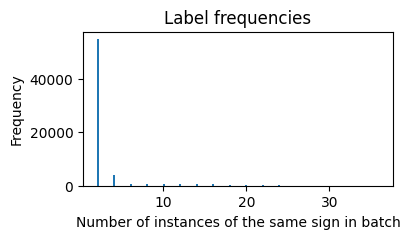

In [7]:
# Checking label counts for each batch, to see if there's no extremely dominant labels
# So we check how frequent each sign is per batch
i = 0
counts = []
for x_batch, y_batch in train_batch_gen:
    y_inds = []
    for y in y_batch.numpy():
        y_inds.append(y)
    # Getting non-duplicate, sorted label counts
    count = sorted(list(Counter(np.array(y_inds)).values()))
    counts += count
    i+=1

print('Number of batches:', i)
print('Label frequencies in the batches:', sorted(Counter(counts).items(), key = lambda x: x[0]))
plt.figure(figsize=(4,2))
plt.hist(counts, bins = batch_size)
plt.xlabel('Number of instances of the same sign in batch')
plt.ylabel('Frequency')
plt.title('Label frequencies')
plt.show()

In [8]:
# We pick a common sign here to see some plots of its embeddings similarity later
labels = load_dict(label_path)
target_num_label = labels['GEBAREN-A']
target_label = find_target_label(target_num_label, labels)

# Creating and training model

In [9]:
# Setting some parameters
temperature = 0.07
learning_rate = 0.001
input_shape = X_train[0].shape
bidirectional = True
masking = False

# Add None to dims if first layer is bi-LSTM (requires specific shape)
if bidirectional and not masking:
    input_shape = (None,) + input_shape

print('Input shape:', input_shape)
# Instantiating the model
model = create_encoder(input_shape, bidirectional, masking, dropout = 0, lstm_dropout = False,
                       num_dense = 2, dense_size = 256, num_lstm = 1, lstm_size = 256, bn = True)
model.build(input_shape)
model.summary()

Input shape: (None, 10, 74)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 512)              677888    
 l)                                                              
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 batch_normalization_1 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                            

Epoch 1
1410/1410 [==============================] - 45s 21ms/step - loss: 0.8752 - val_loss: 0.6756
Ratio of randomly selected negative pairs >= 0.5: 0.869
Ratio of randomly selected positive pairs <= 0.5: 0.229
Ratio of positive pairs for the sign gebaren-a <= 0.5: 0.641


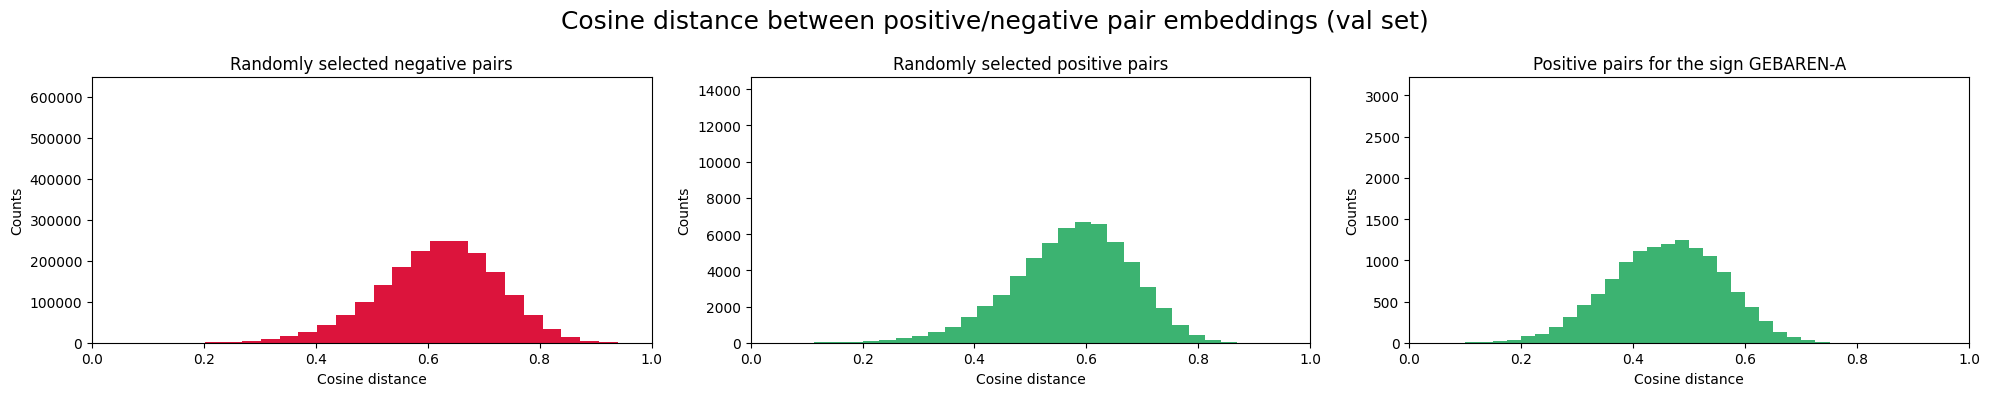

Epoch 2
1410/1410 [==============================] - 35s 18ms/step - loss: 0.7286 - val_loss: 0.6180
Ratio of randomly selected negative pairs >= 0.5: 0.196
Ratio of randomly selected positive pairs <= 0.5: 0.95
Ratio of positive pairs for the sign gebaren-a <= 0.5: 0.998


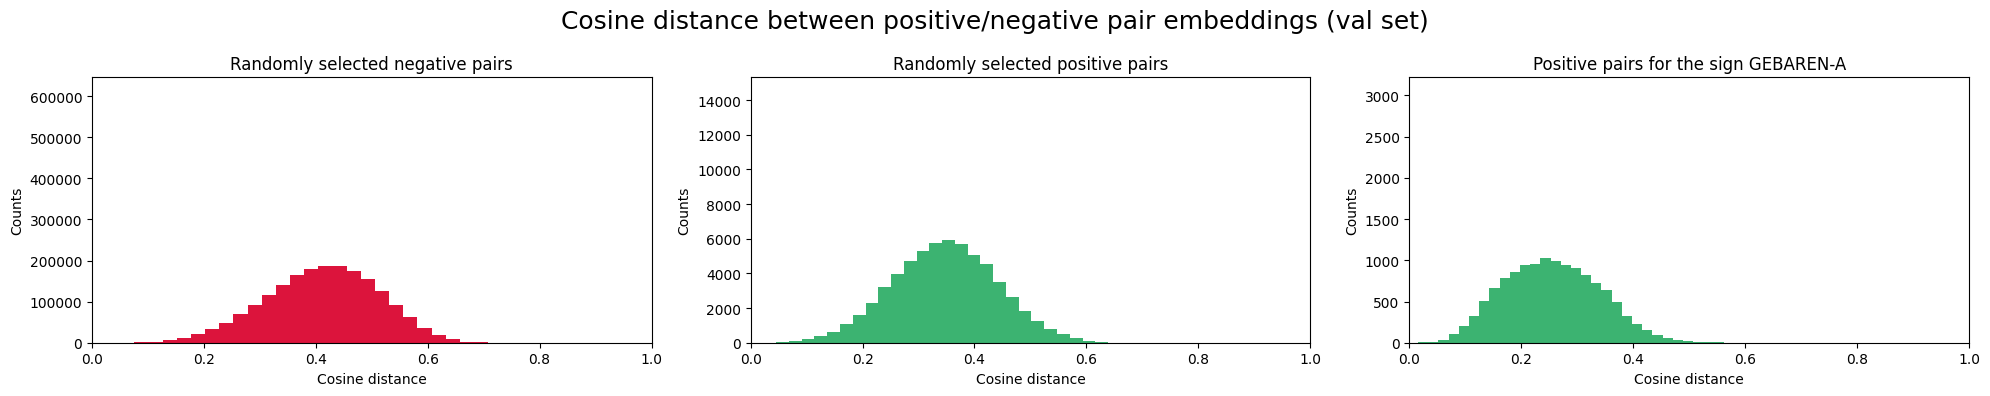

Epoch 3
1410/1410 [==============================] - 36s 19ms/step - loss: 0.6920 - val_loss: 0.6086
Ratio of randomly selected negative pairs >= 0.5: 0.115
Ratio of randomly selected positive pairs <= 0.5: 0.988
Ratio of positive pairs for the sign gebaren-a <= 0.5: 1.0


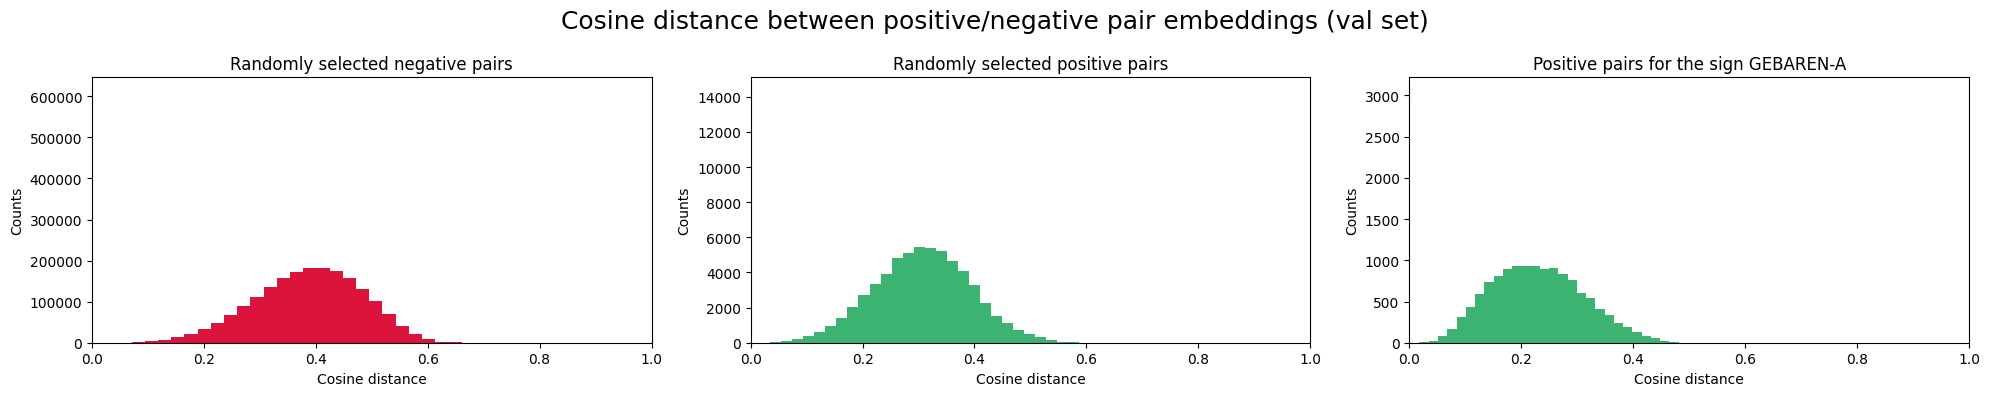

Epoch 4
1410/1410 [==============================] - 34s 18ms/step - loss: 0.6754 - val_loss: 0.6069
Ratio of randomly selected negative pairs >= 0.5: 0.163
Ratio of randomly selected positive pairs <= 0.5: 0.963
Ratio of positive pairs for the sign gebaren-a <= 0.5: 1.0


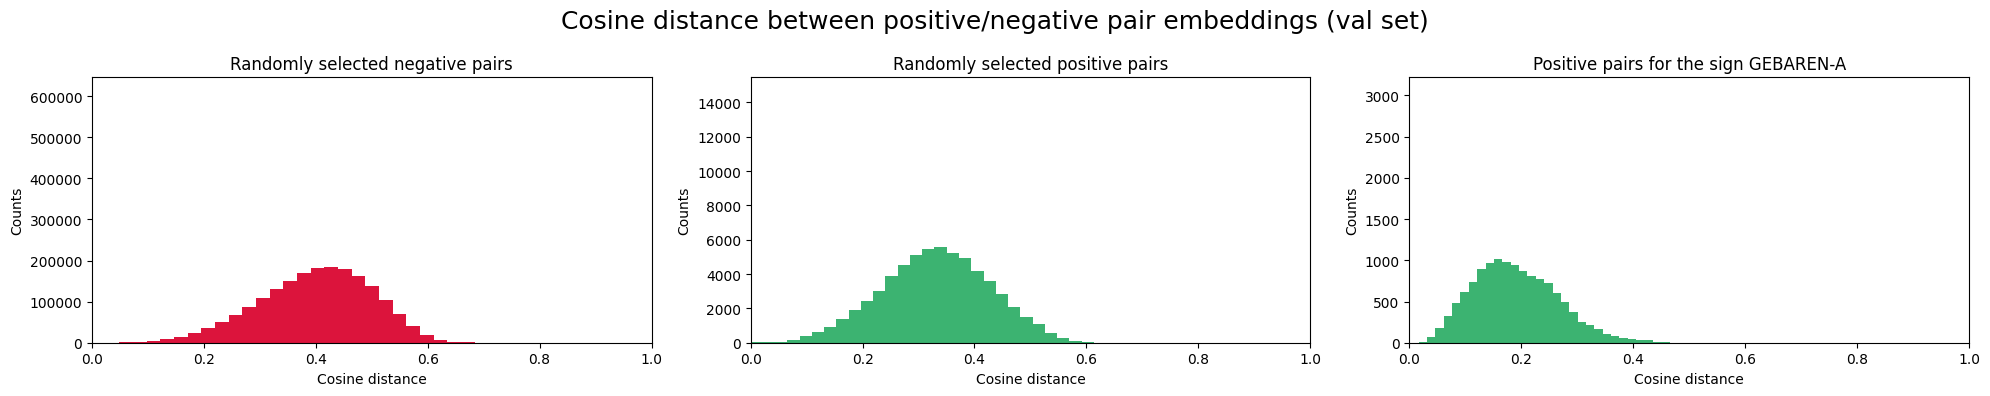

Epoch 5
1410/1410 [==============================] - 34s 18ms/step - loss: 0.6617 - val_loss: 0.5976
Ratio of randomly selected negative pairs >= 0.5: 0.199
Ratio of randomly selected positive pairs <= 0.5: 0.953
Ratio of positive pairs for the sign gebaren-a <= 0.5: 1.0


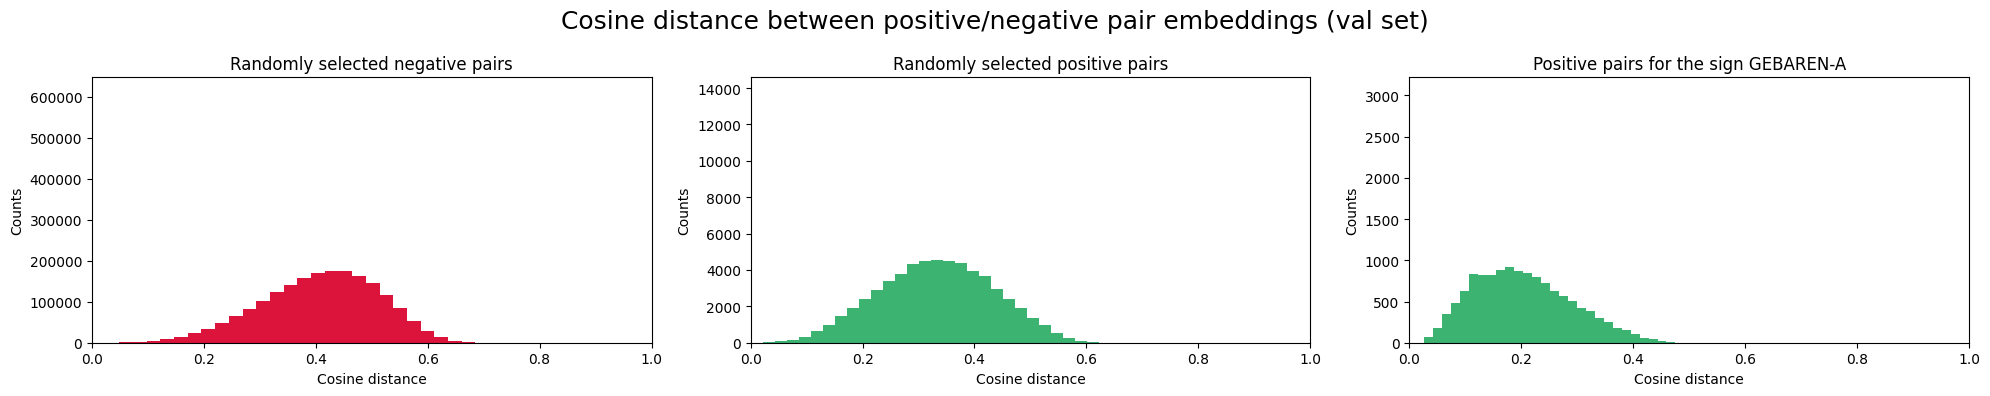

Epoch 6
1410/1410 [==============================] - 35s 18ms/step - loss: 0.6494 - val_loss: 0.5873
Ratio of randomly selected negative pairs >= 0.5: 0.237
Ratio of randomly selected positive pairs <= 0.5: 0.956
Ratio of positive pairs for the sign gebaren-a <= 0.5: 0.998


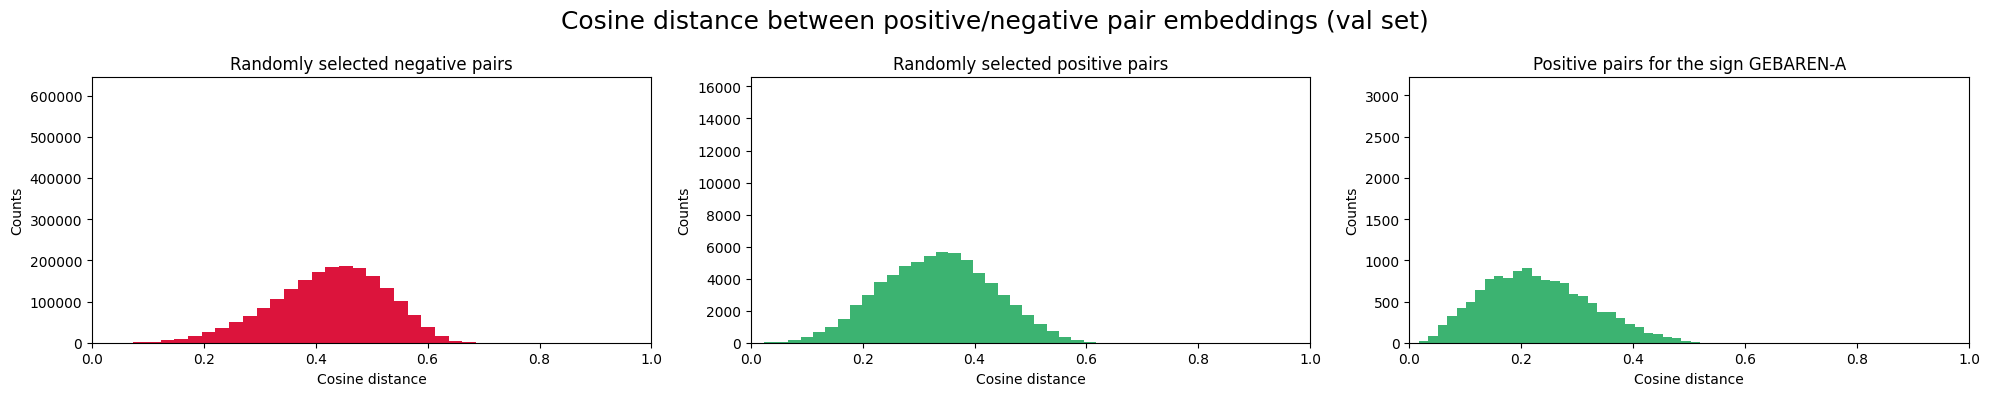

Epoch 7
1410/1410 [==============================] - 34s 18ms/step - loss: 0.6370 - val_loss: 0.5880
Ratio of randomly selected negative pairs >= 0.5: 0.269
Ratio of randomly selected positive pairs <= 0.5: 0.945
Ratio of positive pairs for the sign gebaren-a <= 0.5: 1.0


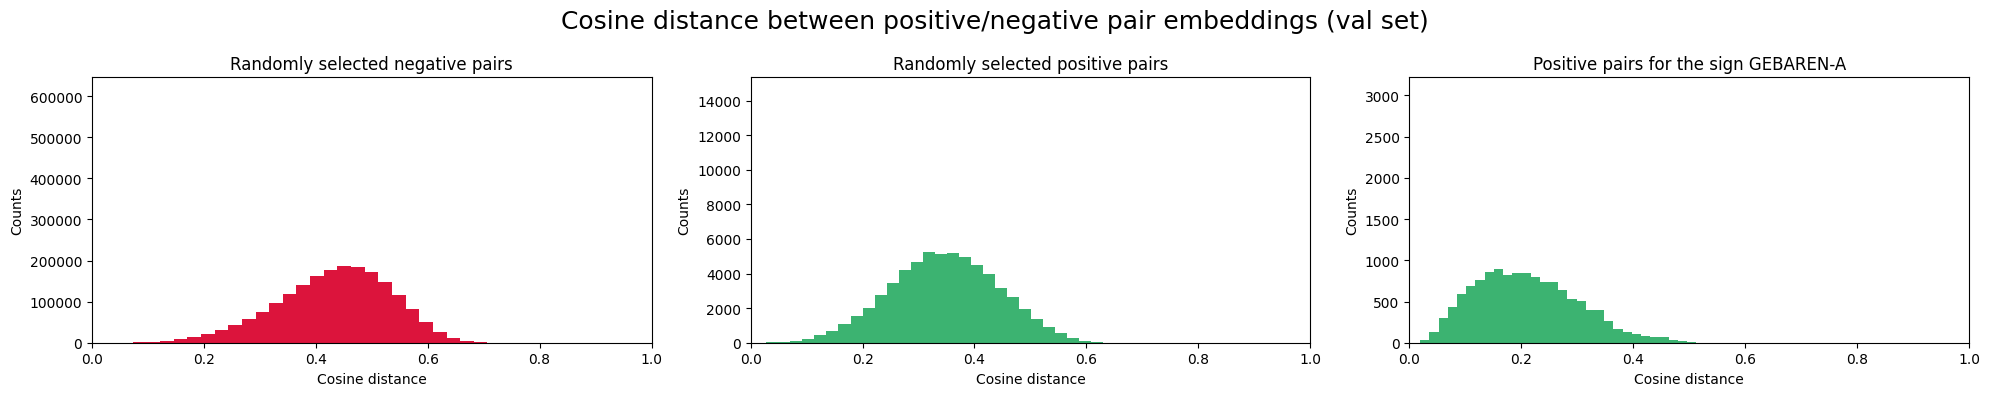

Epoch 8
1410/1410 [==============================] - 34s 18ms/step - loss: 0.6269 - val_loss: 0.5717
Ratio of randomly selected negative pairs >= 0.5: 0.332
Ratio of randomly selected positive pairs <= 0.5: 0.925
Ratio of positive pairs for the sign gebaren-a <= 0.5: 0.992


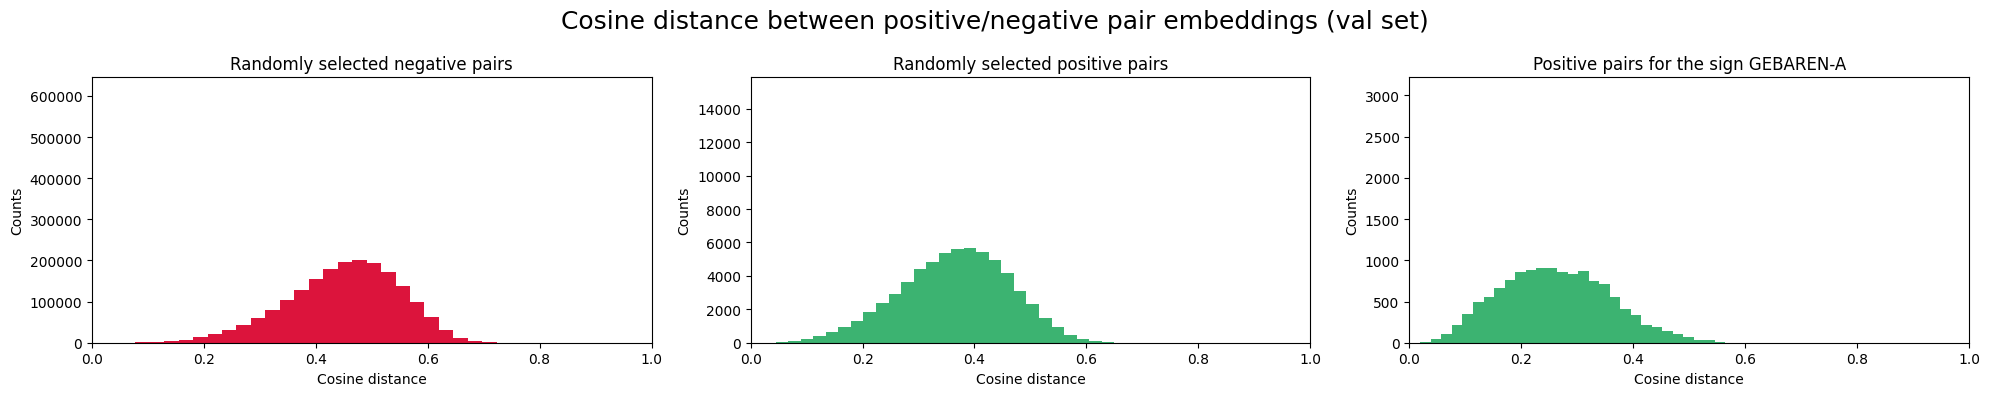

Epoch 9
1410/1410 [==============================] - 35s 19ms/step - loss: 0.6157 - val_loss: 0.5722
Ratio of randomly selected negative pairs >= 0.5: 0.457
Ratio of randomly selected positive pairs <= 0.5: 0.873
Ratio of positive pairs for the sign gebaren-a <= 0.5: 0.998


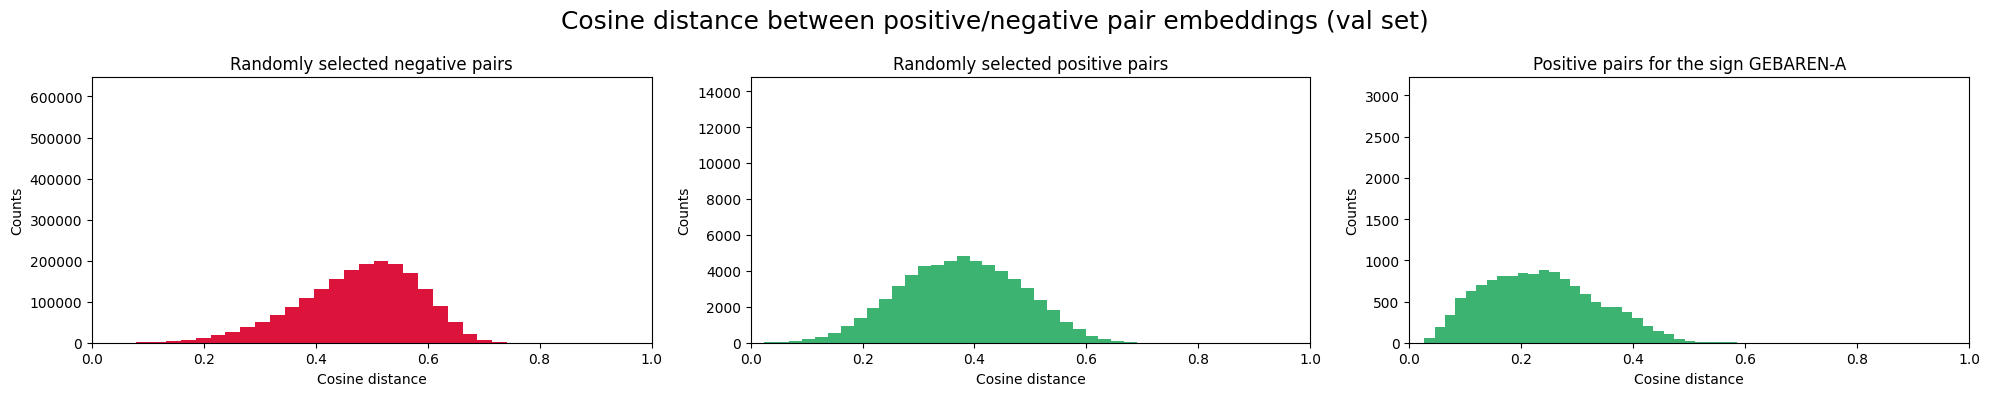

Epoch 10
1410/1410 [==============================] - 34s 18ms/step - loss: 0.6058 - val_loss: 0.5650
Ratio of randomly selected negative pairs >= 0.5: 0.464
Ratio of randomly selected positive pairs <= 0.5: 0.879
Ratio of positive pairs for the sign gebaren-a <= 0.5: 0.986


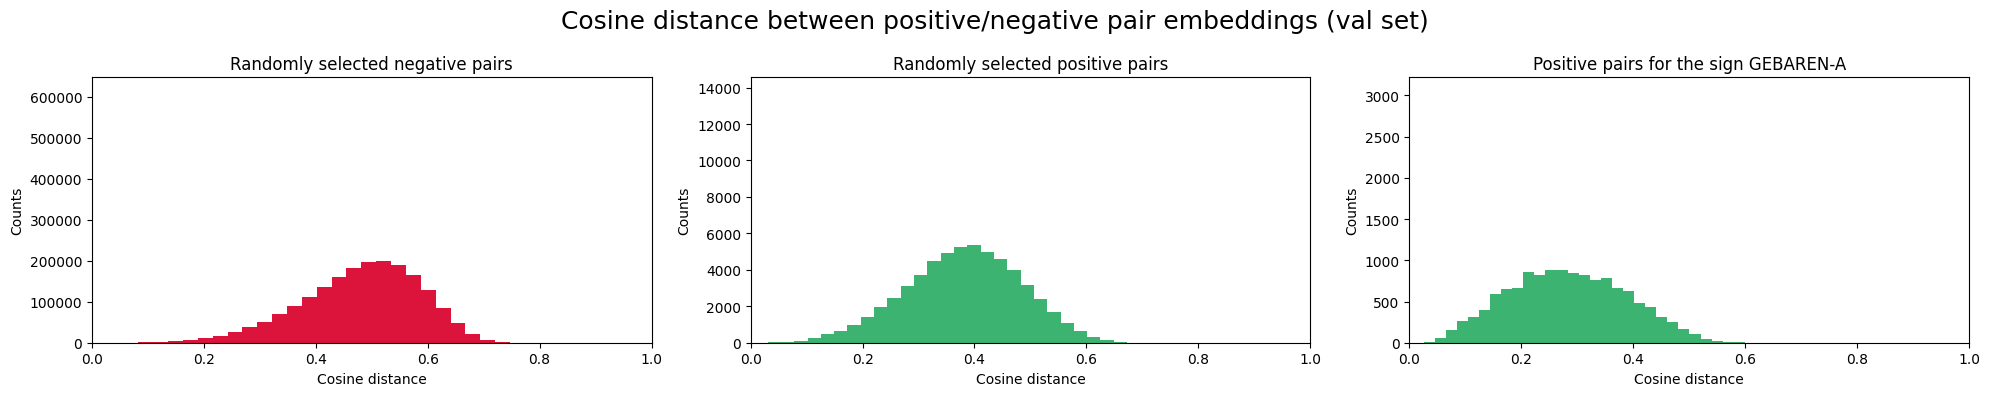

CPU times: total: 9min 22s
Wall time: 7min 24s


In [10]:
%%time
# Note: for each epoch, we plot a sample from the validation set in terms of the cosine distances of its embeddings
# This consists of three subplots: one for all the negative pairs in the sample, where we compare two different signs
# One for positive pairs random embeddings in the sample, where we compare embeddings of the same sign
# And lastly, positive pairs for specifically a common sign (GEBAREN-A) in the data
# Note that the x-axis has the same scale for each subpl ot but the y-axis does NOT
num_epochs = 10
val_losses, train_losses = train_model(model, train_batch_gen, val_batch_gen, X_train, y_train, X_val, y_val, labels,
                                       target_num_label, batch_size, learning_rate, temperature, num_epochs = num_epochs, 
                                       decay_rate = num_epochs, ws = ws, num_classes = num_classes, patience = 2)

In [11]:
# Testing the model with an example
model.compile(optimizer=Adam(learning_rate), loss=SupCon_loss(temperature, num_classes))
for x_batch, y_batch in train_batch_gen:
    print(model.evaluate(x_batch, y_batch, verbose = 0))
    pred = (model.predict(x_batch))
    break
print('Prediction shape', pred.shape)
print('First ten values of example prediction:', pred[0][:10])

0.4742310643196106
4/4 [==============================] - 1s 6ms/step
Prediction shape (128, 256)
First ten values of example prediction: [ 0.85965866 -0.7188788   0.9423479   0.5112176   0.8628684  -1.239881
  0.29634818  2.8250237   0.6371331  -1.3995069 ]


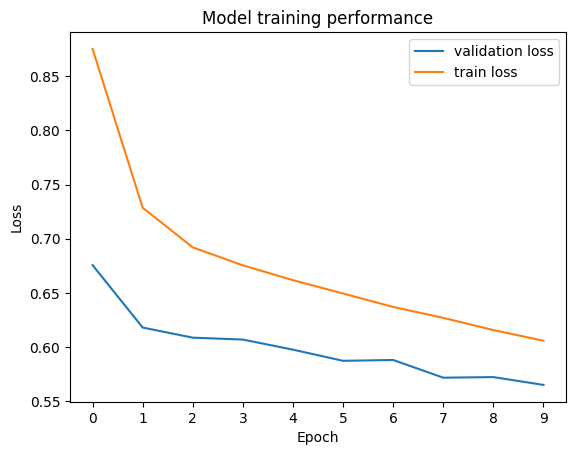

In [12]:
# Plotting the results
plt.title('Model training performance')
plt.plot(val_losses, label = 'validation loss')
plt.plot(train_losses, label = 'train loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(range(len(val_losses)))
plt.legend()
plt.show()

Counts within test: [('PT-1hand', '1993 (int label)', 1057), ('PO', '1941 (int label)', 1001), ('PT-1hand:1', '1994 (int label)', 908), ('GEBAREN-A', '828 (int label)', 144), ('PO+PT', '1942 (int label)', 51), ('GOED-A', '914 (int label)', 100), ('KUNNEN-A', '1335 (int label)', 64), ('HOREN-A', '1097 (int label)', 82), ('ATTENTIE', '222 (int label)', 98), ('WETEN-A', '2770 (int label)', 62)]
Examples: (400, 10, 74)
Prediction result shape: (400, 256)


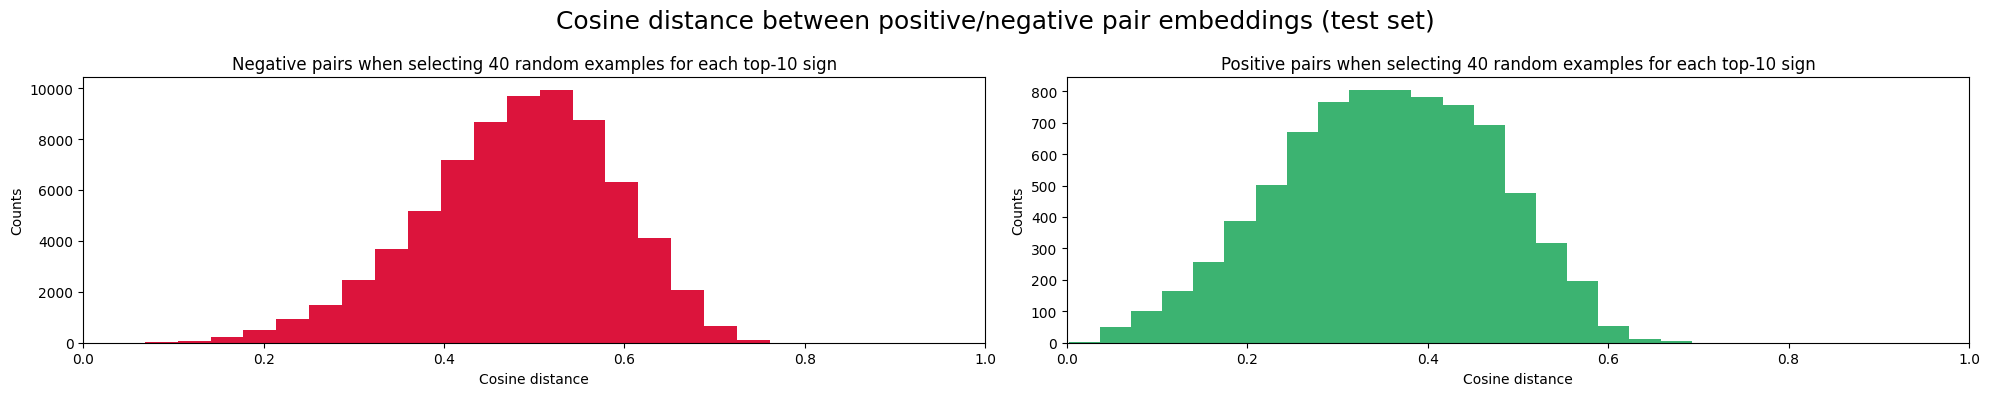

In [13]:
# We take 40 random signs for each of the top 10 most common signs
y_train_counts = sorted(Counter(y_train).items(), key = lambda x: x[-1], reverse = True)
common_sign_sample = []
y_test_top_counts = []
for label, count in y_train_counts[:10]:
    label_inds = np.where(y_test == label)[0]
    str_label = find_target_label(label, labels)[0]
    y_test_top_counts.append((str_label,str(label) + ' (int label)', len(label_inds)))
    label_sample = np.random.choice(label_inds, 40, replace = False)
    common_sign_sample += label_sample.tolist()
print('Counts within test:', y_test_top_counts)
pos_cosines, neg_cosines = compute_cosines(model, common_sign_sample, X_test, y_test)    
    
# Use subplots to plot them next to each other
fig, ax = plt.subplots(1, 2, figsize=(20,4))
fig.suptitle('Cosine distance between positive/negative pair embeddings (test set)', fontsize = 18)
# Random negative pairs
ax[0].hist(neg_cosines, bins = 20, color = 'crimson') # density = True, cumulative = True
ax[0].set_title('Negative pairs when selecting 40 random examples for each top-10 sign')
# Random positive pairs
ax[1].hist(pos_cosines, bins = 20, color = 'mediumseagreen') # density = True, cumulative = True
ax[1].set_title('Positive pairs when selecting 40 random examples for each top-10 sign')
for a in ax:
    a.set_xlim(0,1)
    a.set_ylabel('Counts')
    a.set_xlabel('Cosine distance')
#     a.set_yscale('log')
#     a.set_ylim(1, 10**5)
plt.tight_layout()
plt.show()

In [14]:
%%time
# Plot the distances between the embeddings of the test set
# plot_sim_of_sampled_embds(model, X_test, y_test, target_num_label, labels, num_samples = y_test.shape[0], log = True)

CPU times: total: 0 ns
Wall time: 0 ns


In [15]:
# Getting the counts of each label in the train set, then checking how many labels only occur once
train_label_counts = sorted(Counter(y_train).items(), key = lambda x: x[-1], reverse = True)
print('Num. unique labels in train set:', len(train_label_counts), '\nNum. labels in train set only occuring once:',
      len([t for t in train_label_counts if t[-1] == 1]))

Num. unique labels in train set: 2712 
Num. labels in train set only occuring once: 0


# Creating reference embeddings

In [16]:
# We use only the non-mirrored, not augmented train data to make reference embeddings
y_train_labels = np.array(list(set(y_train_no_mirr)))

# Check here that the last dimension of X_train_no_mirr is the same as X_train!
# Otherwise, you may be using the wrong datasets together (i.e. completely different features)
print('Train data shape (no augmentation or mirroring):', X_train_no_mirr.shape)

Train data shape (no augmentation or mirroring): (90216, 10, 74)


In [17]:
%%time
# Create reference embeddings for all the signs
reference_sign_embds = ref_embds(model, X_train_no_mirr, y_train_no_mirr, y_train_labels, top_ratio = 0.1)

CPU times: total: 4min 12s
Wall time: 3min 50s


# Ranking

In [18]:
%%time
# Show the acc@k for the test set annotations (k = 30, 20, 10 and 5 tested)
# We find how often the train-learned reference embedding is ranked in the top-k most similar embeddings
# Compared to a test embedding of the same sign
X_test_pred = model.predict(X_test, verbose = 0)
top_k_ranking_acc(reference_sign_embds, X_test_pred, y_test, y_train_labels, k_vals = [30,20,10,5])

Number of target signs ranked in top 30: 4948/9585
accuracy@30: 51.62%
Number of target signs ranked in top 20: 4451/9585
accuracy@20: 46.44%
Number of target signs ranked in top 10: 3575/9585
accuracy@10: 37.3%
Number of target signs ranked in top 5: 2768/9585
accuracy@5: 28.88%
CPU times: total: 32.2 s
Wall time: 33.7 s


# Sliding window example

In [19]:
# Get the reference embedding for our common sign example (e.g. 'GEBAREN-A')
reference_res = reference_sign_embds[target_num_label]

In [20]:
%%time
# Get the embedding of each video in the test set using a sliding window
anns, video_embd_dict = make_test_video_embds(model, only_lmrks, X_train)

Loading annotations and getting test video ids...
Loading test video features...
Done.                                                                                                    
CPU times: total: 1min 46s
Wall time: 2min 10s


In [21]:
# Compute the number of annotations in the test videos
num_anns = 0
for video in anns:
    ann = anns[video]
    for sign in ann:
        # We ignore any signs not in the top 1000 (we don't try to spot them)
        if sign in labels: 
            times = ann[sign]
            num_anns += len(set(times))

In [22]:
print('First 10 indices of reference embedding\n', reference_res[:10].tolist())
print('\nindices where reference embedding is zero:', np.where(reference_res.astype(np.float16)==0)[0].tolist())

First 10 indices of reference embedding
 [0.8596577644348145, 0.8740261197090149, 0.9530389904975891, 2.524348020553589, 0.24562408030033112, 1.5448099374771118, 2.453127861022949, 1.0700308084487915, 0.030735580250620842, -1.3933945894241333]

indices where reference embedding is zero: []


In [23]:
# Get the embedding of an entire target video
target_video = 'S053_CNGT1206.eaf' #'S011_CNGT0215' #'S002_CNGT0092'
print('Corpus target video:', target_video)  
result = video_embd_dict[target_video]
anns_dict = anns[target_video]
# Compute the distance of our target sign's reference embedding over the entire target video
dist = cdist(result, reference_res.reshape(1,-1), metric = 'cosine').flatten()

Corpus target video: S053_CNGT1206.eaf


In [24]:
# Get the length of the target video in milliseconds
# We add +3 seconds because the Corpus videos start with a 3 second disclaimer
max_ms = int((3+result.shape[0]/25)*1000)

# Find where the target occurs in the video
if target_label[0] in anns_dict:
    target_times = anns_dict[target_label[0]]
    target_times = list(set(target_times))
    print('Found target times for {}: {}'.format(target_label[0], target_times))
else: # If the target sign is not present, we give out a warning
    print('Warning: target sign {} does not occur in corpus video {}'.format(target_label[0], target_video))
    target_times = []
# target_times.append((-1, -1))

Found target times for GEBAREN-A: [(224920, 225880), (278520, 278760)]


Frame with smallest distance: 5557 (timestamp 0:03:45)
Video: S053_CNGT1206.eaf


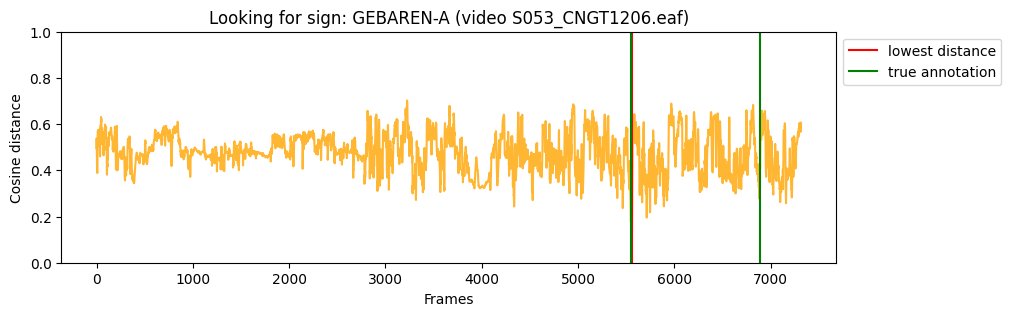

Annotation #1 of GEBAREN-A: 0:03:45-0:03:46
target frames: (5548, 5572)


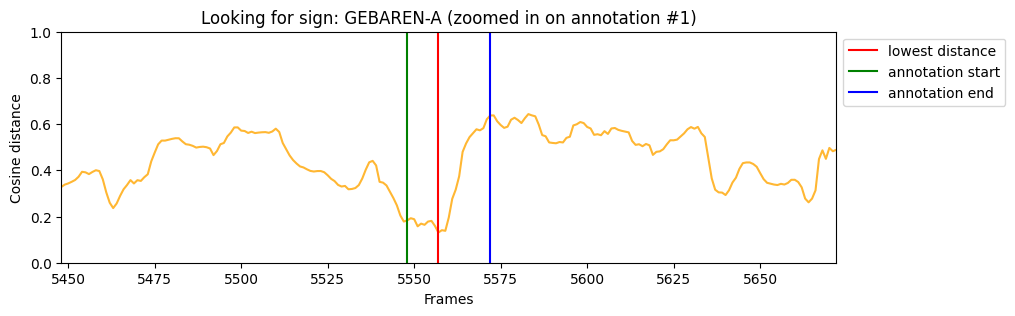

Annotation #2 of GEBAREN-A: 0:04:39-0:04:39
target frames: (6888, 6894)


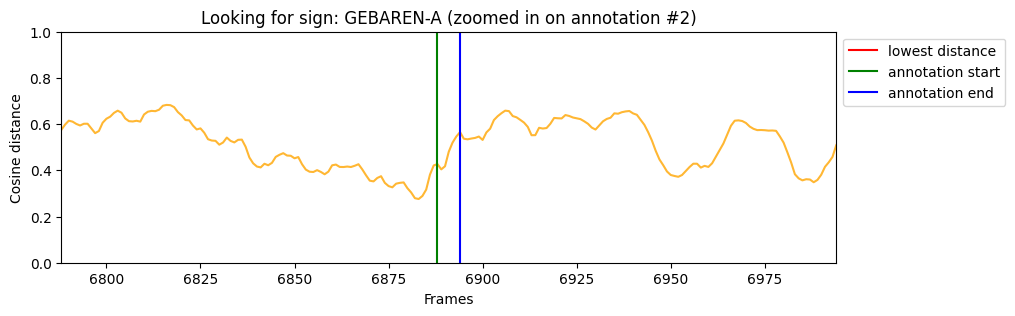

In [25]:
# Setting some default plotting settings that apply both for zoomed out and zoomed in plots
def default_plot_settings(dist, target_sign, title_str, xlim = None, ):
    plt.figure(figsize=(10,3))
    title = 'Looking for sign: ' + target_sign + ' ' + title_str
    plt.title(title)
    # Plot the distances
    plt.plot(dist, color = '#FFA500', alpha = 0.8)
    plt.ylim(0,1)
    # Add line at minimum distance
    plt.axvline(x = np.argmin(dist), color = 'r', label = 'lowest distance')    
    
    if xlim: 
        plt.xlim(xlim[0], xlim[1]) 

#Draw lines at the start and end of each labeled instance of the target sign
window = 100

# Get where the distance is minimal, draw a line there
min_dist = np.argmin(dist)
min_dist_sec = round(3+min_dist/25) # Convert to seconds
print('Frame with smallest distance: {} (timestamp {})'.format(min_dist, sec_to_timestamp(min_dist_sec)))

print('Video:', target_video)

# First, we plot the full video
default_plot_settings(dist, target_label[0], '(video {})'.format(target_video))
for i, target_time in enumerate(target_times):
    # Convert the target times to frames, plot their starting times
    target_frames = (ms_to_frame(target_time[0]), ms_to_frame(target_time[1]))
    # We only add a label for the first ann so the legend doesn't list the same thing multiple times
    plt.axvline(x = target_frames[0], color = 'g', label = 'true annotation' if i == 0 else None)
plt.legend(bbox_to_anchor=(1,1), loc="upper left") 
plt.xlabel('Frames')
plt.ylabel('Cosine distance')
plt.show()

# Zooming in on specific annotations
for i, target_time in enumerate(target_times):
    # Get the start and end timestamps
    start_ts, end_ts = sec_to_timestamp(round(target_time[0]/1000)), sec_to_timestamp(round(target_time[1]/1000))
    print('Annotation #{} of {}: {}-{}'.format(i+1, target_label[0], start_ts, end_ts))

    # Convert the target times to frames, plot their starting times *and* ending times
    target_frames = (ms_to_frame(target_time[0]), ms_to_frame(target_time[1]))
    xlim = (max(0, target_frames[0]-window), min(max_ms, target_frames[1]+window)) 
    default_plot_settings(dist, target_label[0], '(zoomed in on annotation #{})'.format(i+1), xlim = xlim)
    
    print('target frames:', target_frames)
    # We zoom in on an annotation, adding lines where it's annotated
    plt.axvline(x = target_frames[0], color = 'g', label = 'annotation start')
    plt.axvline(x = target_frames[1], color = 'b', label = 'annotation end')
#     plt.xlim(xlim[0], xlim[1]) 
    
    plt.legend(bbox_to_anchor=(1,1), loc="upper left") 
    plt.xlabel('Frames')
    plt.ylabel('Cosine distance')
    plt.show()

# Sign spotting metric

In [26]:
# Convert timestamps in milliseconds to frames
for i, video in enumerate(anns):
    print('video {}/{}'.format(i+1, len(list(anns.keys()))), end = '\r')
    ann = anns[video]
    for sign in ann:
        timestamps = ann[sign]
        frames = [(ms_to_frame(t[0]), ms_to_frame(t[1])) for t in timestamps]
        ann[sign] = frames

In [27]:
%%time
dist_df = pd.read_csv(PATHS['linguistic_distance_df'], index_col = 0)
tolerances = [7.5, 12.5, 75] # In seconds

# Get the distractor's in terms of their timestamps, glosses/signs and their distance to the target sign
distractor_times, distractor_glosses, linguistic_distances = get_distractors(anns, reference_sign_embds, labels,
                                                                             dist_df, tolerance = max(tolerances))

CPU times: total: 1min 7s
Wall time: 1min 9s


In [28]:
%%time
fp_examples = {} # false positives (FPs)
results_list = [[] for _ in range(7)]

thresh = 0.2
# Showing performance for different tolerances
print('Spotting threshold:', thresh)
for t in tolerances: 
    print('Tolerance: {} frames ({} seconds)'.format(t, round(t/25,2)))
    fp_instances, results = compute_spotting_with_tolerance_metric(anns, video_embd_dict, reference_sign_embds, 
                                                                           labels, distractor_times,
                                                                           distractor_glosses, spotting_thresh = thresh, 
                                                                           tolerance = t)
    fp_examples[t] = fp_instances
    for i in range(len(results)):
        results_list[i].append(results[i])
    print('-'*65)

Spotting threshold: 0.2
Tolerance: 7.5 frames (0.3 seconds)
video 123/123
TP: 3562        FP: 826         FN: 6051        TN: 7592        
Accuracy: 0.619	Precision: 0.812	Recall: 0.371
Total judgments: 18031 (9613 targets, 8418 distractors)
-----------------------------------------------------------------
Tolerance: 12.5 frames (0.5 seconds)
video 123/123
TP: 4305        FP: 1094        FN: 5308        TN: 7324        
Accuracy: 0.645	Precision: 0.797	Recall: 0.448
Total judgments: 18031 (9613 targets, 8418 distractors)
-----------------------------------------------------------------
Tolerance: 75 frames (3.0 seconds)
video 123/123
TP: 5376        FP: 2293        FN: 4237        TN: 6125        
Accuracy: 0.638	Precision: 0.701	Recall: 0.559
Total judgments: 18031 (9613 targets, 8418 distractors)
-----------------------------------------------------------------
CPU times: total: 3min 59s
Wall time: 3min 59s


In [29]:
print('Linguistic distances of the top-x distractors, statistics:')
print_stats(linguistic_distances)

Linguistic distances of the top-x distractors, statistics:
mean:	3.2	std:	1.63	median:	3.0


In [30]:
# Look at some examples of FP spottings (for one video and one tolerance -> remove breaks to see more)
for tolerance in fp_examples:
    print('False positives at tolerance (in frames)', tolerance)
    print('_'*100)
    fps_at_tol = fp_examples[tolerance]
    for video in fps_at_tol:
        print('video:', video)
        fps_tol_vid = fps_at_tol[video]
        for sign in fps_tol_vid:
            wrong_spottings = fps_tol_vid[sign]
            if len(wrong_spottings) > 0:
                print('sign {} (train label {})'.format(sign, labels[sign]))
                for wrong_spotting in wrong_spottings:
                    distractor_time, distractor_gloss = wrong_spotting
                    wrong_spotting = frame_to_timestamp(distractor_time[-1])[0]
                    print('spotting distractor {} at time(s) (in mm:ss): {}'.format(distractor_gloss, wrong_spotting))
                print('*'*40)
        break    
        print('-'*60)
    break

False positives at tolerance (in frames) 7.5
____________________________________________________________________________________________________
video: S011_CNGT0206.eaf
sign PT-1hand:1 (train label 1994)
spotting distractor OOK-A at time(s) (in mm:ss): 00:31
****************************************


In [31]:
# print the results so they can easily be added to a Latex table
result_names = ['\\textbf{TP}', '\\textbf{FN}', '\\textbf{FP}', '\\textbf{TN}', 
                '$\pmb{acc@tol}$', '$\pmb{precision@tol}$', '$\pmb{recall@tol}$']
for i, result in enumerate(results_list):
    result = [result_names[i]] + [str(r) for r in result]
    print('\t&\t'.join(result) + ' \\\ \hline')

\textbf{TP}	&	3562	&	4305	&	5376 \\ \hline
\textbf{FN}	&	6051	&	5308	&	4237 \\ \hline
\textbf{FP}	&	826	&	1094	&	2293 \\ \hline
\textbf{TN}	&	7592	&	7324	&	6125 \\ \hline
$\pmb{acc@tol}$	&	0.619	&	0.645	&	0.638 \\ \hline
$\pmb{precision@tol}$	&	0.812	&	0.797	&	0.701 \\ \hline
$\pmb{recall@tol}$	&	0.371	&	0.448	&	0.559 \\ \hline
